In [1]:
#!/usr/bin/env python
# coding: utf-8

#########
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs
import copy
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')



In [2]:
# loop ensemble members
start = 0
stop = start+1
for em in range(start,stop):

    ### Preprocessing ###
    ## Load SST
    ddir = '/home/disk/atmos/vcooper/work/p2c2/lgm/'
#     dfile = 'lgmDA_hol_SST_monthly_climo.nc'
    dfile = 'lgmDA_hol_SST_monthly_ens.nc'
    ncf = ddir + dfile
    tempds = xr.open_dataset(ncf)
    tempds = tempds.set_coords(['lat','lon','month','ens'])
    # tempds = xr.merge([tempds.set_coords(['lat','lon','month','ens']).sst,
    #                    tempds.set_coords(['lat','lon','month','ens']).ens])
    holo_sst_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1)).isel(nEns=em)
    holo_sst_climo['mask'] = xr.where(~np.isnan(holo_sst_climo.sst.isel(nmonth=0)), 1, 0)

    dfile = 'lgmDA_lgm_SST_monthly_ens.nc'
    ncf = ddir + dfile
    tempds = xr.open_dataset(ncf)
    tempds = tempds.set_coords(['lat','lon','month','ens'])
    lgm_sst_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1)).isel(nEns=em)
    lgm_sst_climo['mask'] = xr.where(~np.isnan(lgm_sst_climo.sst.isel(nmonth=0)), 1, 0)

    ## Load ICEFRAC
    dfile = 'lgmDA_hol_ICEFRAC_monthly_ens.nc'
    ncf = ddir + dfile
    tempds = xr.open_dataset(ncf).set_coords(['lat','lon','month','ens'])
    holo_ice_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1)).isel(nEns=em)
    holo_ice_climo['mask'] = xr.where(~np.isnan(holo_ice_climo.icefrac.isel(nmonth=0)), 1, 0)

    dfile = 'lgmDA_lgm_ICEFRAC_monthly_ens.nc'
    ncf = ddir + dfile
    tempds = xr.open_dataset(ncf).set_coords(['lat','lon','month','ens'])
    lgm_ice_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1)).isel(nEns=em)
    lgm_ice_climo['mask'] = xr.where(~np.isnan(lgm_ice_climo.icefrac.isel(nmonth=0)), 1, 0)
    #####################

    ## regrid the lgm sst onto the sea ice grid
    newgrid = lgm_ice_climo # desired grid
    data_for_regridding = lgm_sst_climo

    regridder = xe.Regridder(data_for_regridding, newgrid,
                             method='bilinear',#ignore_degenerate=True,
                             periodic=True,
                             filename='bilinear_sst_to_ice_per.nc',
                             reuse_weights=True)
#     print(regridder)

    ## regrid the lgm sst onto the sea ice grid
    newgrid = holo_ice_climo # desired grid
    data_for_regridding = holo_sst_climo

    regridder_holo = xe.Regridder(data_for_regridding, newgrid,
                             method='bilinear',#ignore_degenerate=True,
                             periodic=True,
                             filename='bilinear_sst_to_ice_per_holo.nc',
                             reuse_weights=True)

    ############# ICE SHEET ADJUSTMENTS ######
    # THIS VERSION HAS NOT GONE THROUGH HURRELL ADJUSTMENTS
    # SO IT IS CONSISTENT WITH Infilling>IceSheet>Meridian>Hurrell>BCGEN
    path = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
    # lgm_ice_merged = xr.open_dataset(
    #     path + 'lgmDA_lgm_ICEFRAC_monthly_climo_merged_v2.nc').set_coords(['lat','lon'])
    # lgm_sst_merged = xr.open_dataset(path + 
    #                                      'lgmDA_lgm_SST_monthly_climo_merged.nc')
    ice6g = xr.open_dataset('/home/disk/sipn/vcooper/nobackup/lgm/peltier_lgm-mask/' + 'I6_C.VM5a_1deg.21.nc')
    ice6g_0 = xr.open_dataset('/home/disk/sipn/vcooper/nobackup/lgm/peltier_lgm-mask/' + 'I6_C.VM5a_1deg.0.nc')

    ## SST (icefrac is already on 1.9x2.5 grid)
    # amip2000['mask'] = xr.where(~np.isnan(amip2000.SST_cpl[0]),1,0) ## dummy mask
    newgrid = lgm_ice_climo.icefrac[0] # desired grid
    data_for_regridding = ice6g
    data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sftlf),1,0)

    regridder_ice6g = xe.Regridder(data_for_regridding, newgrid,
                             method='bilinear',
                             periodic=True,
    #                          extrap_method='inverse_dist',extrap_num_src_pnts=64,
                             filename='bilinear_noextrapc.nc',
                             reuse_weights=True)

    ice6g_regrid = regridder_ice6g(data_for_regridding)
    # ice6g_0_regrid = regridder_ice6g(ice6g_0)

    ## store new data in this dataset
    icecombo_all = lgm_ice_climo.icefrac.to_dataset().copy(
        data={'icefrac':np.zeros_like(lgm_ice_climo.icefrac.values)})

    for msel in range(12):

    # msel=2
        mstr = str(msel+1).zfill(2)

        path = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
        merged_load = xr.open_dataset(path + 
                                         'lgmDA_lgm_SST_monthly_climo_merged_' + mstr +'.nc')
        merged_load = merged_load.sst

        ds = lgm_sst_climo.sst[msel]
        ds_ice = lgm_ice_climo.icefrac[msel]

        ds_holo = holo_sst_climo.sst[msel]
        ds_ice_holo = holo_ice_climo.icefrac[msel]
        ds_ice_holo_wmask = holo_ice_climo

        ds_temp_icegrid = regridder(ds)
        ds_holo_icegrid = regridder_holo(ds_holo)
        ds_temp_icegrid['mask'] = ~np.isnan(ds_temp_icegrid)
        ds_holo_icegrid['mask'] = ~np.isnan(ds_holo_icegrid)

        merged_icegrid = regridder_holo(merged_load)
        merged_icegrid['mask'] = xr.where(~np.isnan(merged_icegrid),1,0)
        merged_load['mask'] = xr.where(~np.isnan(merged_load),1,0)

        ## extrapolate the regridding to cover all cells with sea ice, since there 
        ## are some sea ice locations that show up as nan SST
        newgrid = holo_ice_climo.icefrac[msel]
        newgrid = newgrid.to_dataset()
        newgrid['icefrac'] = newgrid.icefrac.where(newgrid.icefrac > 0.01)
        newgrid['mask'] = xr.where(~np.isnan(newgrid.icefrac),1,0)
        newgrid

        data_for_regridding = merged_load.drop('mask').to_dataset(name='sst')
        data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst),1,0)
        data_for_regridding

        regridder_extrap = xe.Regridder(data_for_regridding, newgrid,
                                 method='bilinear',
                                 periodic=True,
                                 extrap_method='inverse_dist',
                                 filename='bilinear_mergedSST_to_holoSIC_per_extrapID.nc',
                                 reuse_weights=True)

        merged_icegrid_extrap = regridder_extrap(data_for_regridding)

        ## this now has all of the places where we need sea ice
        merged_icegrid = xr.where(
            np.isnan(merged_icegrid_extrap.sst),
            merged_icegrid,merged_icegrid_extrap.sst)
        merged_icegrid['mask'] = xr.where(~np.isnan(merged_icegrid),1,0)

        ## subset data to fit SIC vs. SST lowess relation; only use NH for fit
    #     sub_sic = ds_ice.where(ds_ice.lat > 10).values[
    #         (ds_ice>0.01) & (ds_temp_icegrid > -1.78) & (ds_temp_icegrid < 1.5)]
    #     sub_sst = ds_temp_icegrid.where(ds_temp_icegrid.lat > 10).values[
    #         (ds_ice>0.01) & (ds_temp_icegrid > -1.78) & (ds_temp_icegrid < 1.5)]
        # use holocene data for the fit since more relevant to infilling
        sub_sic = ds_ice_holo.where(ds_holo_icegrid.lat > 10).values[
            (ds_ice_holo>0.01) & (ds_holo_icegrid > -1.8) & (ds_holo_icegrid < 3)]
        sub_sst = ds_holo_icegrid.where(ds_holo_icegrid.lat > 10).values[
            (ds_ice_holo>0.01) & (ds_holo_icegrid > -1.8) & (ds_holo_icegrid < 3)]


        ## lowess regression in seaborn
        df = pd.DataFrame(np.vstack([sub_sst,sub_sic]).T,columns=['sst','sic'])

        f = sns.regplot(x='sst', y='sic',data=df,
                        lowess=True, scatter_kws={"alpha": 0.1,'color':'k'},color='royalblue')
        fit = f.lines[0].get_xydata()
        plt.clf()

        ## adjust fit to manually add on ends to -2,100% and 1.0,0%
        xfit = np.append(np.linspace(-2,fit[:,0][0],5),
                         np.append(fit[:,0],3))
        yfit = np.append(np.linspace(1,fit[:,1][1],5),
                         np.append(fit[:,1],0))
        yfit = np.clip(yfit,0,1)  ## prevent getting icefrac outside of 0 to 1

        ## where masks are different (and there isnt ice already), need to check for new ice

        ## lgm mask: either there is an SST from regridded, or there is more than 1% ice
        # NB: need to add the 1% ice check because native ice grid appears to have
        # sea ice where regridding yields land
        lgmmask = ~np.isnan(ds_temp_icegrid) | (ds_ice > 0.01)
        # lgmmask.plot()
        # plt.show()

        ## new mask is all of the new, regridded SSTs where there could be sea ice
        newmask = ~np.isnan(merged_icegrid)
        # newmask.plot()
        # plt.show()

        ## diffmask is only places where sea ice should potentially be added
        diffmask = xr.where((newmask > 0) & (lgmmask < 1),1,0)
        # diffmask.plot()
        # plt.show()

        ## get all of the SSTs for cells that were previously masked
        sst_ofnewice = merged_icegrid.where(diffmask==1)

        ## NORTHERN HEMISPHERE
        ## find closest SIC based on lowess fit
        yind = np.argmin(
            (sst_ofnewice.values[:,:,np.newaxis] - xfit)**2,axis=2)
        newsic = yfit[yind.ravel()].reshape(yind.shape)
        icecombo = xr.where(diffmask != 0, newsic, ds_ice)

        ## SOUTHERN HEMISPHERE
        ## use xesmf extrapolation
        newgrid = holo_ice_climo.icefrac[msel]
        newgrid = newgrid.to_dataset()
        newgrid['icefrac'] = newgrid.icefrac.where(newgrid.icefrac > 0.01)
        newgrid['mask'] = xr.where(~np.isnan(newgrid.icefrac),1,0)
        newgrid

        data_for_regridding = ds_ice.to_dataset(name='icefrac')
        data_for_regridding['mask'] = xr.where(~np.isnan(ds_temp_icegrid) | (ds_ice>0.01),1,0)
        data_for_regridding['icefrac'] = data_for_regridding.icefrac.where(data_for_regridding.mask > 0)
        data_for_regridding

        regridder_SICextrap = xe.Regridder(data_for_regridding, newgrid,
                                 method='bilinear',
                                 periodic=True,
                                 extrap_method='inverse_dist',extrap_num_src_pnts=8*4,
        #                          filename='bilinear_mergedSST_to_holoSIC_per_extrapID.nc',
                                 reuse_weights=False)

        ice_extrap = regridder_SICextrap(data_for_regridding)

        diffmask2 = xr.where((newgrid.mask > 0) & 
                         (newgrid.mask != data_for_regridding.mask),1,0)

        merged_icegrid2 = xr.where(diffmask2 != 0, ice_extrap.icefrac, ds_ice)

        merged_icegrid2['mask'] = xr.where(~np.isnan(merged_icegrid2),1,0)

        ## put NH and SH together
        icecombo2 = xr.where(icecombo.lat < 0, merged_icegrid2, icecombo)

        #### ICE SHEET ADJ
        ## set minimum icefrac to be ice sheet frac
        icecombo2 = xr.where(icecombo2*100 < ice6g_regrid.sftgif.values, 
                                   ice6g_regrid.sftgif.values/100, icecombo2)

        #### ICE SHEET ADJ
        ## set minimum icefrac to be ice sheet frac
        icecombo2 = xr.where(icecombo2*100 < ice6g_regrid.sftgif.values, 
                                   ice6g_regrid.sftgif.values/100, icecombo2)

        ## adjustment along meridians to patch in gaps
        latmin=68
        for imer,val in enumerate(icecombo2.transpose('nLon',...)):
            valnh = val.where(val.lat > latmin)

            ## check maximum ice poleward and equatorward, along meridian
            max_ice_poleward = np.array([valnh[j:].max() for j in range(len(valnh))])
            max_ice_equatorward = np.array([valnh[0:j+1].max() for j in range(len(valnh))])

            ## ice ceiling is maximum value ice will increase to. don't go below the original
            ## ice value, and don't go above the maximum SIC poleward of position
            ice_ceiling = np.array([np.max([p,v]) for p,v in zip(max_ice_poleward,valnh)])
            max_ice_equatorward = np.where((max_ice_equatorward > valnh) & (max_ice_equatorward > ice_ceiling), 
                                       ice_ceiling, max_ice_equatorward)

            val = xr.where(val.lat > latmin, max_ice_equatorward, val)
            icecombo2[:,imer] = val

        icecombo_all.icefrac[msel] = icecombo2
#         print(msel)

    ## SAVE FILES
    emstring = str(em+1).zfill(4)
    savepath = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/ens/'
    fname_merged = 'lgmDA_lgm_ICEFRAC_monthly_ens'+ emstring +'_merged_v3.nc'
    icecombo_all.to_netcdf(savepath + fname_merged)

    print('finished saving ens mem' + emstring, fname_merged)

    


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_sst_to_ice_per.nc 
Reuse pre-computed weights? True 
Input grid shape:           (384, 320) 
Output grid shape:          (96, 144) 
Periodic in longitude?      True
0
1
2
3
4
5
6
7
8
9
10
11
finished saving ens mem0001 lgmDA_lgm_ICEFRAC_monthly_ens0001_merged_v3.nc


<Figure size 432x288 with 0 Axes>

In [27]:
## CHECKS

import cartopy.feature as cfeature
temp = xr.open_dataset('/home/disk/sipn/vcooper/nobackup/lgm/infilled/ens/'+'lgmDA_lgm_ICEFRAC_monthly_ens'+ '0003' +'_merged_v3.nc')
temp2 = xr.open_dataset('/home/disk/sipn/vcooper/nobackup/lgm/infilled/ens/'+'lgmDA_lgm_ICEFRAC_monthly_ens'+ '0005' +'_merged_v3.nc')

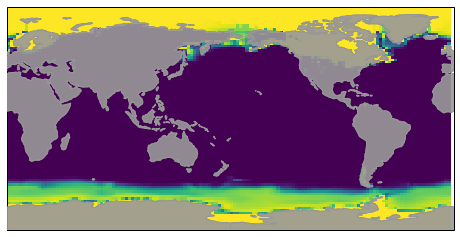

In [28]:
proj = ccrs.PlateCarree(central_longitude=180)
fig,ax = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.add_feature(cfeature.LAND,zorder=5,alpha=0.9,color='0.6')
plt.pcolormesh(temp.lon,temp.lat,
               temp.icefrac[i],
               transform=ccrs.PlateCarree(),
               cmap='viridis',alpha=1)
plt.show()

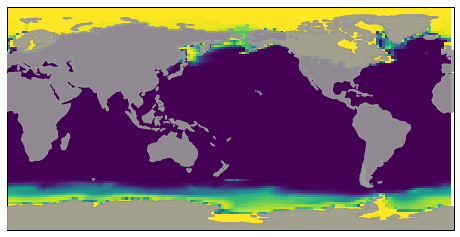

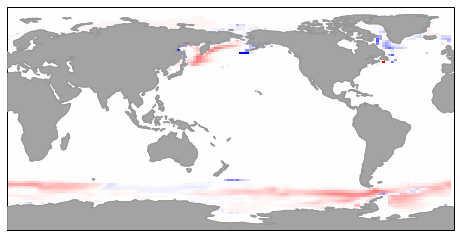

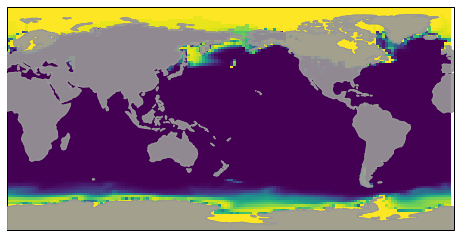

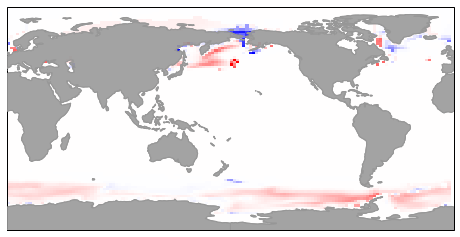

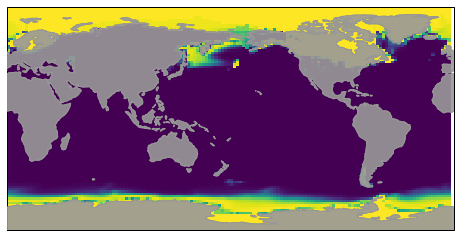

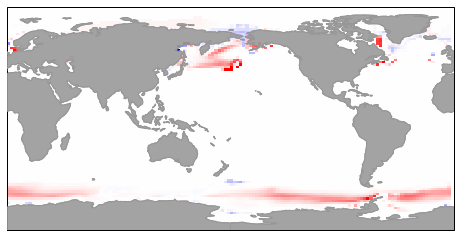

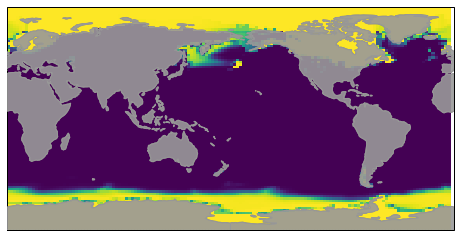

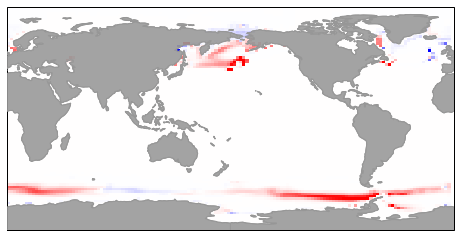

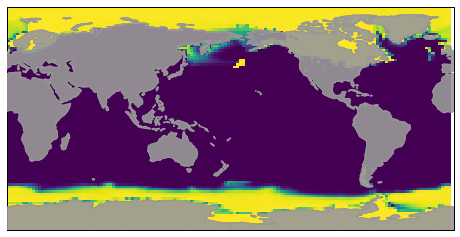

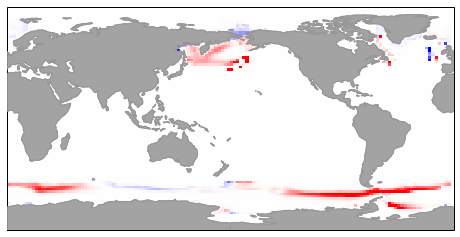

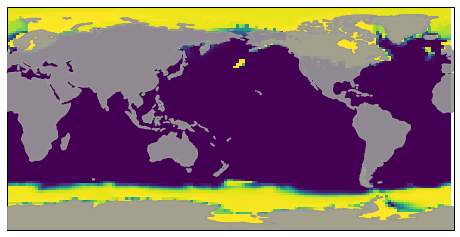

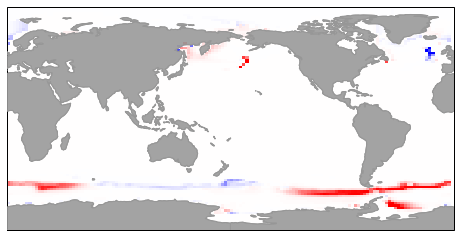

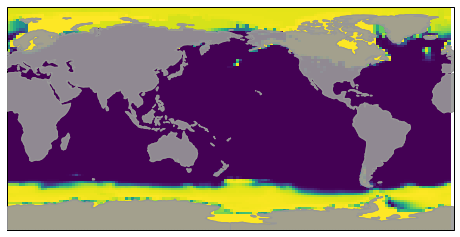

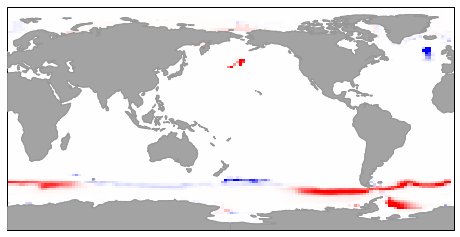

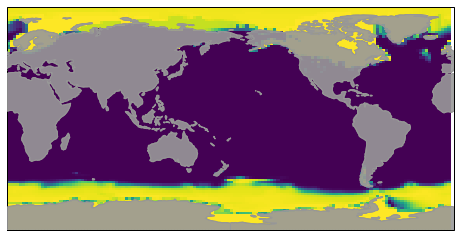

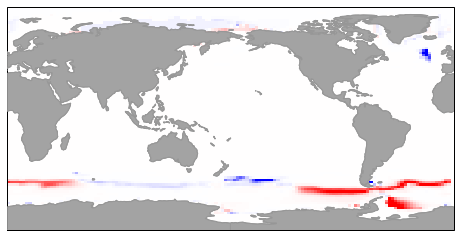

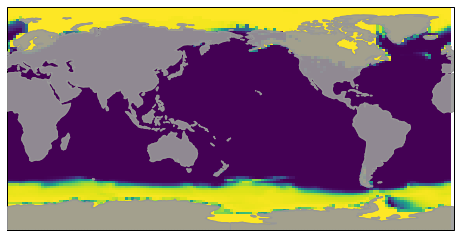

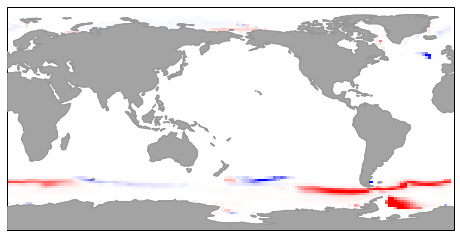

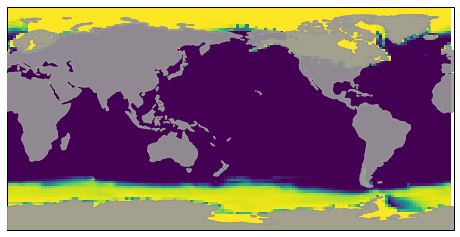

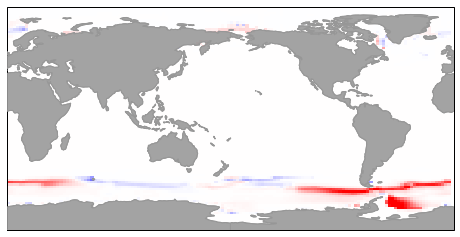

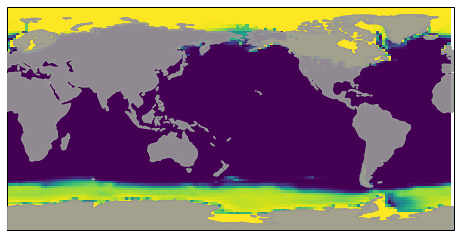

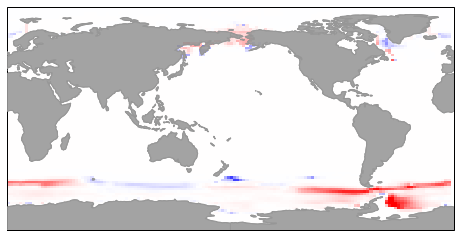

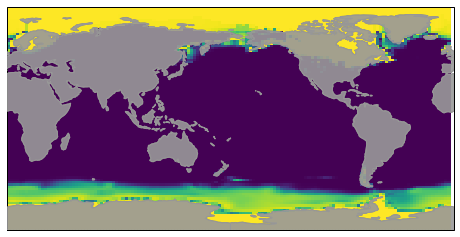

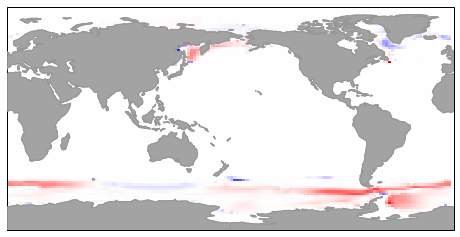

In [29]:
for i in range(12):
    proj = ccrs.PlateCarree(central_longitude=180)
    fig,ax = plt.subplots(figsize=(8,6))
    ax = plt.subplot(projection=proj)
    ax.coastlines(color='0.5')
    ax.add_feature(cfeature.LAND,zorder=5,alpha=0.9,color='0.6')
    plt.pcolormesh(temp.lon,temp.lat,
                   temp2.icefrac[i],
                   transform=ccrs.PlateCarree(),
                   cmap='viridis',alpha=1)
    plt.show()
    
    fig,ax = plt.subplots(figsize=(8,6))
    ax = plt.subplot(projection=proj)
    ax.coastlines(color='0.5')
    ax.add_feature(cfeature.LAND,zorder=5,alpha=0.9,color='0.6')
    plt.pcolormesh(temp.lon,temp.lat,
                   temp.icefrac[i] - temp2.icefrac[i],
                   transform=ccrs.PlateCarree(),
                   cmap='bwr',alpha=1,vmax=0.5,vmin=-0.5)
    plt.show()